# Vector Graphics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, randint
from time import time
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import Turtle, VectorImage

-----

# A) Turtle Graphics

See `drawing.py` for the implementation of the Turtle.

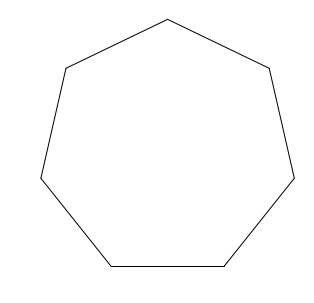

In [3]:
def polygon(turtle, n, a=1):
    for i in range(n):
        turtle.forward(a)
        turtle.left(360 / n)
    return turtle
           
polygon(Turtle(), 7).show()

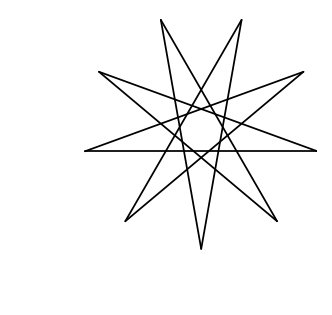

In [3]:
def star(turtle, n, skip, a=1):
    for i in range(n):
        turtle.forward(a)
        turtle.left(360 * skip / n)
    return turtle
           
star(Turtle(), 9, 4).show()

-----

# B) Relative vs. Absolute Drawing

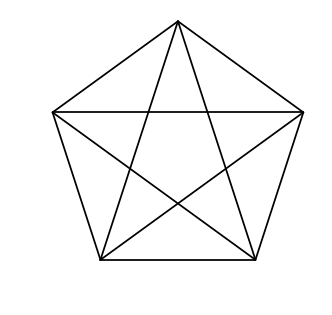

In [4]:
def pentagon_rel():
    turtle = Turtle()
    polygon(turtle, 5)
    turtle.left(360/10)
    length = 2 * sin((pi - 2*pi / 5)/2)  # TODO: simplify + use radians
    star(turtle, 5, 2, length)
    turtle.show()
    
pentagon_rel()

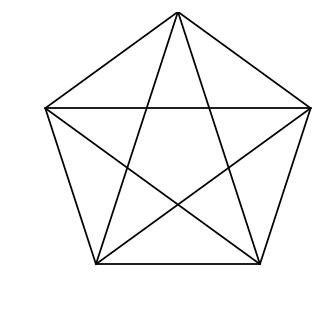

In [5]:
def pentagon_abs():
    im = VectorImage()
    angles = [radians(90 + i * 360/5) for i in range(5)]
    vertices = [(cos(angle), sin(angle)) for angle in angles]
    for i in range(5):
        im.line(vertices[i], vertices[(i+1) % 5])
        im.line(vertices[i], vertices[(i+2) % 5])
    
pentagon_abs()

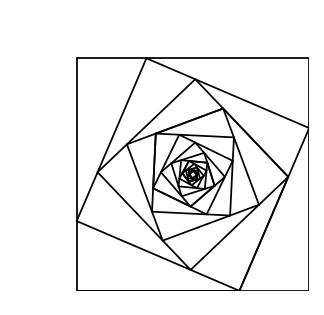

In [6]:
# Relative drawing
def nested_squares(n, length=1, shift=0.7):
    turtle = Turtle()
    angle = degrees(atan(shift/(1-shift)))
    for i in range(n):
        polygon(turtle, 4, a=length)
        turtle.forward(shift * length)
        turtle.left(angle)
        length = shift * length / sin(radians(angle))       
    turtle.show()

nested_squares(15)

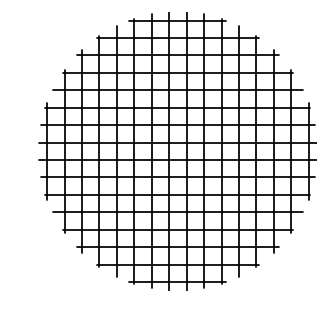

In [7]:
# Absolute drawing
def grid_circle(n_lines=16, radius=1):
    im = VectorImage()
    step = 2 * radius / (n_lines - 1)
    mid_line = (n_lines - 1) / 2
    for i in range(n_lines):
        dist1 = radius * 2 * (i - mid_line) / n_lines
        dist2 = sqrt(radius**2 - dist1**2) 
        im.line([-dist2, dist1], [dist2, dist1])
        im.line([dist1, -dist2], [dist1, dist2])   
    
grid_circle()

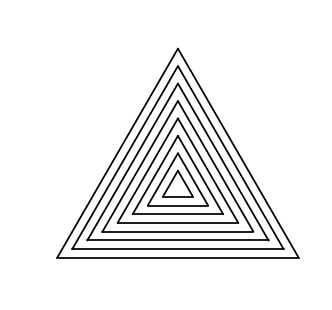

In [8]:
# Absolute drawing
def centered_equilateral_triangle(im, length):
    angles = [radians(90 + i * 120) for i in range(3)]
    vertices = [
        (cos(angle) * length, sin(angle) * length)
        for angle in angles]
    for i in range(3):
        im.line(vertices[i], vertices[(i+1) % 3])
    
def nested_triangles(n=8, length=1):
    im = VectorImage()
    for i in range(n+1):
        centered_equilateral_triangle(im, length * i / n)        

nested_triangles()

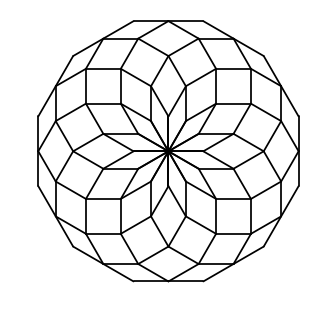

In [9]:
# Relative drawing
def multipolygon(n, length=1):
    turtle = Turtle()
    angle = 360 / n
    for i in range(n):
        polygon(turtle, n, a=length)
        turtle.left(angle)     
    turtle.show()

multipolygon(12)

-----

# C) Fractals

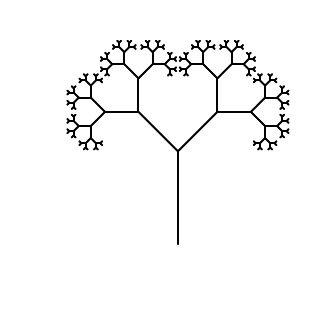

In [10]:
def tree_rec(turtle, n, length=1, shrinking=0.6):
    if n == 0:
        return turtle
    turtle.forward(length)
    turtle.left(45)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.right(90)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.left(45)
    turtle.back(length)
    return turtle

def tree(n=8):
    turtle = Turtle()
    turtle.left(90)
    turtle = tree_rec(turtle, n)
    turtle.show()

tree()

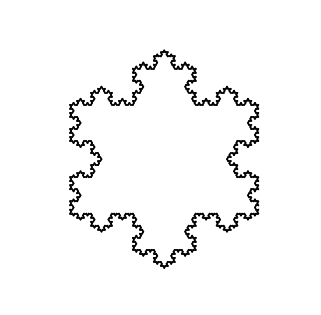

In [11]:
def koch_line(turtle, n, length=1):
    if n == 0:
        turtle.forward(length)
        return
    koch_line(turtle, n-1, length)
    turtle.left(60)
    koch_line(turtle, n-1, length)
    turtle.right(120)
    koch_line(turtle, n-1, length)
    turtle.left(60)
    koch_line(turtle, n-1, length)

def koch_flake(n):
    turtle = Turtle()
    for i in range(3):
        koch_line(turtle, n)
        turtle.right(120)
    turtle.show()

koch_flake(n=4)

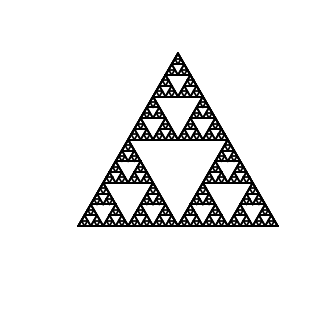

In [13]:
def sierpinski_triangle(n, length=1):   
    def sierpinski_rec(n, length):
        if n == 0:
            return
        for i in range(3):
            sierpinski_rec(n-1, length/2)
            turtle.forward(length)
            turtle.left(120)
    
    turtle = Turtle()
    sierpinski_rec(n, length)
    turtle.show()

sierpinski_triangle(n=6)

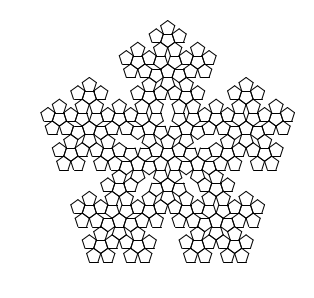

In [8]:
def pentagon(turtle, length):
    for i in range(5):
        turtle.forward(length)
        turtle.left(360 / 5)
        
def pentagon_flake(n, length=1):   
    def flake_rec(n, length):
        if n == 0:
            pentagon(turtle, length)
            return
        nested_length = shrinking_ratio * length
        # Outside pentagons.
        for i in range(5):
            flake_rec(n-1, nested_length)
            turtle.forward(length, draw=False)
            turtle.left(360/5)
        # Inside pentagon: get to its corner, draw it, get back.
        turtle.forward(nested_length, draw=False)
        turtle.left(360/5)        
        turtle.forward(nested_length, draw=False)
        angle = 180 - 108 - 36
        turtle.right(angle)
        flake_rec(n-1, nested_length)
        turtle.left(angle)
        turtle.back(nested_length, draw=False)
        turtle.right(360/5)        
        turtle.back(nested_length, draw=False)
    
    turtle = Turtle()
    shrinking_ratio = 1 / (2 * (1 + sin(radians(18))))
    flake_rec(n, length)
    turtle.show()

pentagon_flake(n=3)

-----

# D) Creative Turtle

Recursive tree with addedd randomness and decreasing line widths to make it look more realistic:

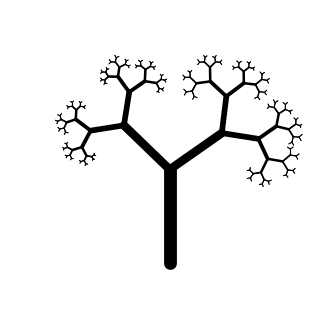

In [15]:
def tree_rec(turtle, n=8, length=1,
             shrinking_min=0.5, shrinking_max=0.7, randomness=6):
    if n == 0:
        return turtle
    turtle.forward(length, linewidth=1.5 ** n / 2)
    left_angle = 50 + randint(-randomness, randomness)
    right_angle = 50 + randint(-randomness, randomness)
    turtle.left(left_angle)
    shrinking = shrinking_min + random() * (shrinking_max-shrinking_min)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.right(left_angle + right_angle)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.left(right_angle)
    turtle.back(length)
    return turtle

def random_tree():
    turtle = Turtle()
    turtle.left(90)
    turtle = tree_rec(turtle)
    turtle.show()

random_tree()

Using multiple turtles:

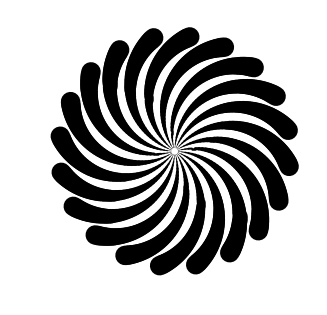

In [38]:
def spinning_star(n_legs, n_steps=40):
    turtles = [Turtle() for _ in range(n_legs)]
    for i, turtle in enumerate(turtles):
        turtle.right(int(360 * i / n_legs))
    for i_step in range(n_steps):
        for turtle in turtles:
            #turtle.right(randint(2, 5))
            turtle.right(3)
            turtle.forward(1, linewidth=20 * i_step/n_steps)
    im = VectorImage()
    for turtle in turtles:
        turtle.show(im=im)

spinning_star(n_legs=20)

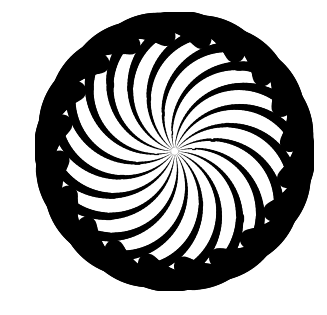

In [42]:
spinning_star(n_legs=20, n_steps=80)

Adding some randomness in the mix:

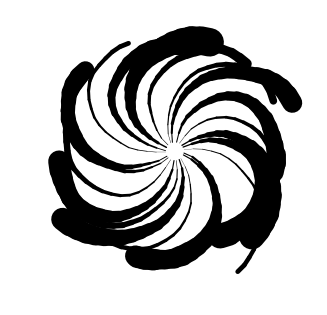

In [36]:
def random_spinning_star(n_legs, n_steps=20):
    turtles = [Turtle() for _ in range(n_legs)]
    widths = [randint(5, 30) for _ in range(n_legs)]
    for i, turtle in enumerate(turtles):
        turtle.right(int(360 * i / n_legs))
    for i_step in range(n_steps):
        for turtle, width in zip(turtles, widths):
            turtle.right(randint(3, 15))
            turtle.forward(1, linewidth=width * i_step/n_steps)
    im = VectorImage()
    for turtle in turtles:
        turtle.show(im=im)

random_spinning_star(n_legs=20)